# Imbalanced classes experiment, Part 1: General Considerations
## May 1st, 2018
### Dr Jose M Albornoz

An experiment to determine good class imbalance compensation strategies. 

An artificially imbalanced dataset with two classes is generated, and the separation between classes in feature space is changed to explore the effect of conventional strategies used to tackle imbalanced classes.

## Conclusions:
1. **Balanced classes, clear separation in feature space**: ideal situation, the choice of estimator is not critical.
1. **Imbalanced classes, clear separation in feature space**: good estimator performance, the choice of estimator is not critical
3. **Balanced classes, no clear separation in feature space, both classes have similar variance**: it's basically a coin flip
4. **Balanced classes, no clear separation in feature space, positive class has low variance**: random forest and decision tree estimators outperform logistic regression (classes not linearly separable)
5. **Imbalanced classes, no clear separation between classes, positive class has low variance**: Surprisingly, a decision trees estimator has an acceptable performance in this case. This is a case that might benefit from reesampling.
6. **Imbalanced classes, no clear separation between classes, both classes have similar variance**: No estimator provides meaningful results - basically a coin flip. This is a case that might benefit from resampling

# Import necessary modules

In [319]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
%matplotlib inline

import numpy as np
import seaborn as sbs
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
from sklearn.cross_validation import cross_val_score
from sklearn.utils import resample
from sklearn.learning_curve import validation_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import seaborn as sns

RANDOM_STATE = 801

# 1 Generate data

## 1.1 Number of samples in each class, class varaiance, and class separation

In [320]:
# Case 1: Balanced classes, good separation in feature space
# n_samples1 = 4000
# n_samples2 = 4000

# sigma1 = 0.9
# sigma2 = 0.9

# offset_x1 = -2.0
# offset_x2 = 0

# Case 2: Imbalanced classes, good separation in feature space
# n_samples1 = 4000
# n_samples2 = 200

# sigma1 = 0.9
# sigma2 = 0.9

# offset_x1 = -2.0
# offset_x2 = 0

# Case 3: Balanced classes, no clear separation in feature space, both classes have similar variance
# n_samples1 = 4000
# n_samples2 = 4000

# sigma1 = 0.1
# sigma2 = 0.1

# offset_x1 = 2.6
# offset_x2 = -.1

# Case 4: Balanced classes, no clear separation in feature space, positive class has low variance
# n_samples1 = 4000
# n_samples2 = 4000

# sigma1 = 0.9
# sigma2 = 0.1

# offset_x1 = 2.6
# offset_x2 = -.1

# Case 5: Imbalanced classes, no clear separation between classes, positive class has low variance
# n_samples1 = 4000
# n_samples2 = 200

# sigma1 = 0.9
# sigma2 = 0.1

# offset_x1 = 2.6
# offset_x2 = -.1

# Case 6: Imbalanced classes, no clear separation between classes, both classes have similar variance
n_samples1 = 4000
n_samples2 = 200

sigma1 = 0.9
sigma2 = 0.9

offset_x1 = 2.6
offset_x2 = -.1

## 1.2 Class separation

In [321]:
# Case 1: Balanced classes, good separation in feature space
# offset_x1 = -1.5
# offset_x2 = 0

# offset_x1 = 2.5
# offset_x2 = 2.5
# offset_x1 = 1.6
# offset_x2 = 1.6
# offset_x1 = 0.5
# offset_x2 = 0.5
# offset_x1 = 2.6
# offset_x2 = -.1


## 1.3 Generate dataset

In [322]:
from sklearn.datasets import make_blobs
X1, y1 = make_blobs(n_samples=n_samples1, n_features=2, centers=1, cluster_std=sigma1, shuffle=True, random_state=0)
X2, y2 = make_blobs(n_samples=n_samples2, n_features=2, centers=1, cluster_std=sigma2, shuffle=True, random_state=1)

In [323]:
y2 = np.ones(n_samples2)

In [324]:
X2[:,0] = X2[:,0] + offset_x1

In [325]:
X2[:,1] = X2[:,1] + offset_x2

In [326]:
X = np.concatenate((X1, X2), axis=0)

In [327]:
y = np.concatenate((y1, y2))

In [328]:
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=0)

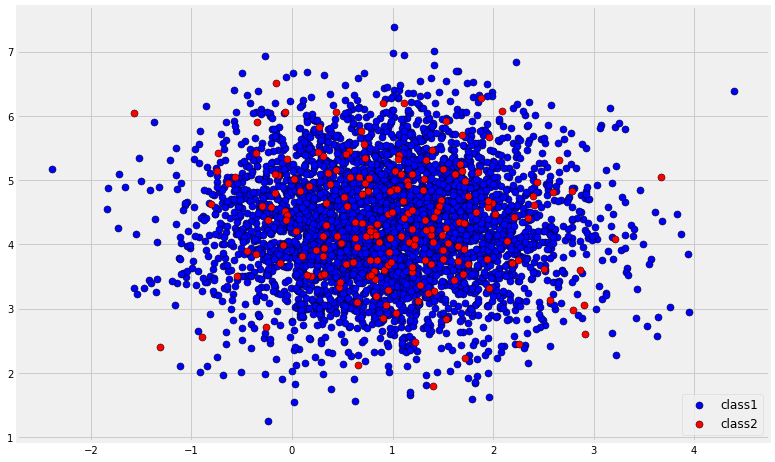

In [329]:
plt.figure(figsize=(12,8))
plt.scatter(X[y==0,0], X[y==0,1], c='blue', marker='o', edgecolor='black', s=50, label = 'class1')
plt.scatter(X[y==1,0], X[y==1,1], c='red', marker='o', edgecolor='black', s=50, label='class2')
plt.legend(loc='lower right', fontsize=12)

# 2 Training and tests sets

In [330]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=RANDOM_STATE)

# 3 Data normalisation

In [331]:
scl = StandardScaler()    

In [332]:
scl.fit(X_train_raw)
X_train = scl.transform(X_train_raw)

In [333]:
X_test = scl.transform(X_test_raw)

# 4 Model Definition

In [334]:
clf1 = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1) 

In [335]:
clf2 = DecisionTreeClassifier(random_state=RANDOM_STATE)

In [336]:
clf3 = LogisticRegression(tol=0.1, random_state=RANDOM_STATE)

## 4.2 Model fitting

In [337]:
model1 = clf1.fit(X_train, y_train)

In [338]:
model2 = clf2.fit(X_train, y_train)

In [339]:
model3 = clf3.fit(X_train, y_train)

## 4.3 Performance on test set

In [340]:
y_pred1 = model1.predict(X_test)

In [341]:
y_pred2 = model2.predict(X_test)

In [342]:
y_pred3 = model3.predict(X_test)

In [343]:
# random forest
accuracy_score(y_test, y_pred1)

0.950937950937951

In [344]:
# decision tree
accuracy_score(y_test, y_pred2)

0.9083694083694084

In [345]:
# logistic regression
accuracy_score(y_test, y_pred3)

0.9523809523809523

## 4.4 Confusion Matrix

In [346]:
np.bincount(y_train.astype(int))

array([2680,  134])

In [347]:
np.bincount(y_test.astype(int))

array([1320,   66])

In [348]:
confusion1 = confusion_matrix(y_test, y_pred1)
confusion1

array([[1318,    2],
       [  66,    0]])

Text(0.5,1,'Random Forest')

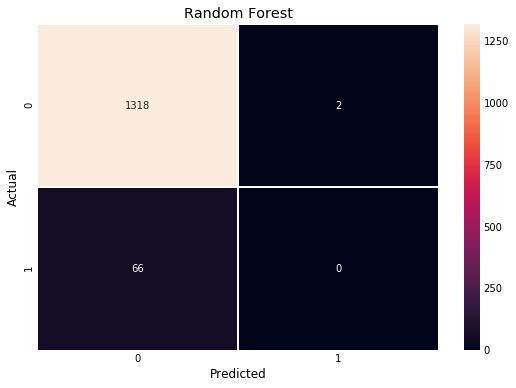

In [349]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(confusion1, annot=True, fmt="d", linewidths=.5)
ax.set(xlabel='Predicted', ylabel='Actual')
ax.set_title('Random Forest')

In [350]:
confusion2 = confusion_matrix(y_test, y_pred2)
confusion2

array([[1253,   67],
       [  60,    6]])

Text(0.5,1,'Decision tree')

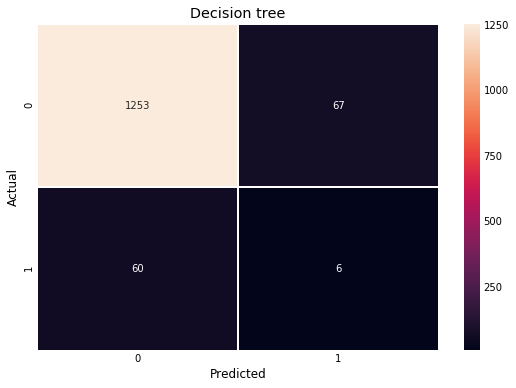

In [351]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(confusion2, annot=True, fmt="d", linewidths=.5)
ax.set(xlabel='Predicted', ylabel='Actual')
ax.set_title('Decision tree')

In [352]:
confusion3 = confusion_matrix(y_test, y_pred3)
confusion3

array([[1320,    0],
       [  66,    0]])

Text(0.5,1,'Logistic regression')

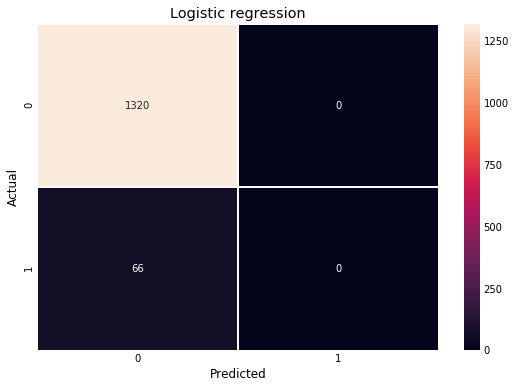

In [353]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(confusion3, annot=True, fmt="d", linewidths=.5)
ax.set(xlabel='Predicted', ylabel='Actual')
ax.set_title('Logistic regression')

## 4.5 Accuracy

In [354]:
# Overall, how often is the classifier correct?
# random forest
accuracy_score(y_test, y_pred1)

0.950937950937951

In [355]:
# Overall, how often is the classifier correct?
# decision tree
accuracy_score(y_test, y_pred2)

0.9083694083694084

In [356]:
# Overall, how often is the classifier correct?
# logistic regression
accuracy_score(y_test, y_pred3)

0.9523809523809523

## 4.6 Classification error

In [357]:
# Overall, how often is the classifier incorrect?
# random forest
1 - accuracy_score(y_test, y_pred1)

0.04906204906204903

In [358]:
# Overall, how often is the classifier incorrect?
# decision tree
1 - accuracy_score(y_test, y_pred2)

0.09163059163059162

In [359]:
# Overall, how often is the classifier incorrect?
# logistic regression
1 - accuracy_score(y_test, y_pred3)

0.04761904761904767

## 4.7 Recall

In [360]:
# When the actual value is positive, how often is the prediction correct?
# random forest
recall_score(y_test, y_pred1)

0.0

In [361]:
# When the actual value is positive, how often is the prediction correct?
# decision tree
recall_score(y_test, y_pred2)

0.09090909090909091

In [362]:
# When the actual value is positive, how often is the prediction correct?
# logistic regression
recall_score(y_test, y_pred3)

0.0

## 4.8 Precision

In [363]:
# When a positive value is predicted, how often is the prediction correct?
# random forest
precision_score(y_test, y_pred1)

0.0

In [364]:
# When a positive value is predicted, how often is the prediction correct?
# decision tree
precision_score(y_test, y_pred2)

0.0821917808219178

In [365]:
# When a positive value is predicted, how often is the prediction correct?
# logistic regression
precision_score(y_test, y_pred3)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

## 4.9 ROC curve

In [366]:
# Compute fpr, tpr, thresholds and roc auc
probs1 = clf1.predict_proba(X_test)
y_score1 = probs1[:,1]
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_score1)
roc_auc1 = auc(fpr1, tpr1)

In [367]:
# Compute fpr, tpr, thresholds and roc auc
probs2 = clf2.predict_proba(X_test)
y_score2 = probs2[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_score2)
roc_auc2 = auc(fpr2, tpr2)

In [368]:
# Compute fpr, tpr, thresholds and roc auc
probs3 = clf3.predict_proba(X_test)
y_score3 = probs3[:,1]
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_score3)
roc_auc3 = auc(fpr3, tpr3)

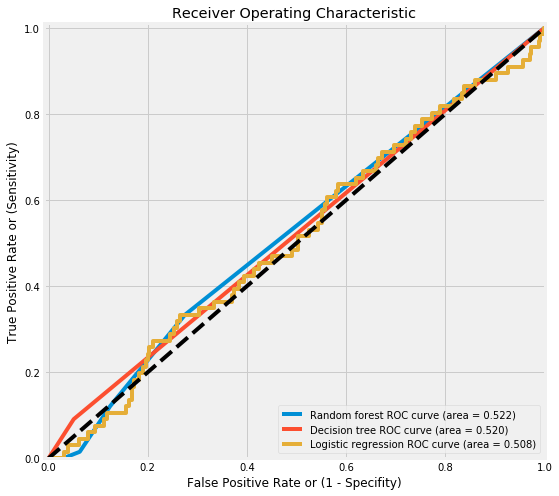

In [369]:
plt.figure(figsize=(8,8))
plt.plot(fpr1, tpr1, label='Random forest ROC curve (area = %0.3f)' % roc_auc1)
plt.plot(fpr2, tpr2, label='Decision tree ROC curve (area = %0.3f)' % roc_auc2)
plt.plot(fpr3, tpr3, label='Logistic regression ROC curve (area = %0.3f)' % roc_auc3)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

## 4.10 Precision-recall curve

In [370]:
precision1, recall1, _ = precision_recall_curve(y_test, y_score1)
precision2, recall2, _ = precision_recall_curve(y_test, y_score2)
precision3, recall3, _ = precision_recall_curve(y_test, y_score3)

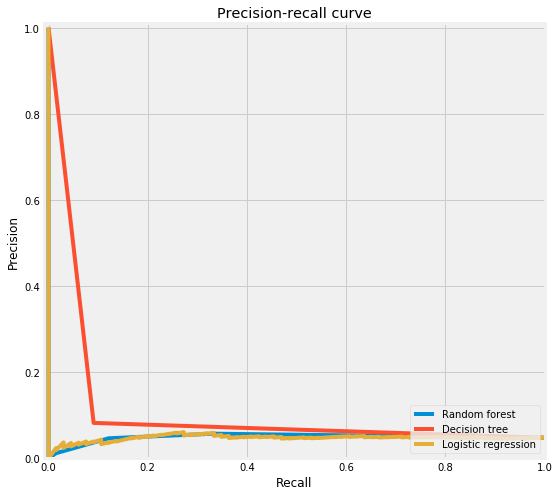

In [371]:
plt.figure(figsize=(8,8))
plt.plot(recall1, precision1, label='Random forest')
plt.plot(recall2, precision2, label='Decision tree')
plt.plot(recall3, precision3, label='Logistic regression')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curve')
plt.legend(loc="lower right")